# Lab1. Custom Object Detection with SageMaker built-in algorithm

In this lab, you will build a model to recognize license plate area from images that we generated in Lab0.  
You can run all notebook cells at once.  
It may **take 25~30 minutes** in total.


## Preparing Object Detection data

* Divide train and valdiation data from generated images
* od, od/train, od/validation folders will be used to store the divided data

In [1]:
import os 

In [2]:
#!rm -fR od
!mkdir od od/od-train od/od-train_annotation od/od-validation od/od-validation_annotation

In [3]:
jsons = os.listdir('gen/gen-tags')
print ('There are {:,} images have annotation files'.format(len(jsons)))

There are 10,000 images have annotation files


* Define the number of train/valdiation images

In [4]:
n_samples = len(jsons)
n_val = 5000 if n_samples > 25000 else round(n_samples * 0.2)
n_train = n_samples - n_val
print('{:,} images will be used for training, and {:,} images will be used for validation.'.format(n_train, n_val))

8,000 images will be used for training, and 2,000 images will be used for validation.


* Move images and annotation files to od-train and od-validation folders  
 (Cropped-imgs and nums-tags files are not moved.)

In [5]:
import shutil

train_jsons = jsons[:n_train]
val_jsons = jsons[n_train:]

#Moving training files to the training folders
for i in train_jsons:
    image_file = './gen/gen-imgs/'+i.split('.')[0]+'.png'
    shutil.copy(image_file, './od/od-train/')
    shutil.copy('./gen/gen-tags/'+i, './od/od-train_annotation/')

#Moving validation files to the validation folders
for i in val_jsons:
    image_file = './gen/gen-imgs/'+i.split('.')[0]+'.png'
    shutil.copy(image_file, './od/od-validation/')
    shutil.copy('./gen/gen-tags/'+i, './od/od-validation_annotation/')

* check the copy result

In [6]:
print('there are {:,} files in gen/gen-imgs folder.'.format(len(os.listdir('gen/gen-imgs'))))
print('there are {:,} files in gen/gen-tags folder.'.format(len(os.listdir('gen/gen-tags'))))
print('there are {:,} files in od/od-train folder.'.format(len(os.listdir('od/od-train'))))
print('there are {:,} files in od/od-train_annotation folder.'.format(len(os.listdir('od/od-train_annotation'))))
print('there are {:,} files in od/od-validation folder.'.format(len(os.listdir('od/od-validation'))))
print('there are {:,} files in od/od-validation_annotation folder.'.format(len(os.listdir('od/od-validation_annotation'))))

there are 10,000 files in gen/gen-imgs folder.
there are 10,000 files in gen/gen-tags folder.
there are 8,000 files in od/od-train folder.
there are 8,000 files in od/od-train_annotation folder.
there are 2,000 files in od/od-validation folder.
there are 2,000 files in od/od-validation_annotation folder.


## Upload the data to S3

* Set the SageMaker Session to upload data to S3

In [7]:
from PIL import Image
import json
import matplotlib.image as mpimg

In [8]:
import sagemaker
from sagemaker import get_execution_role

role = get_execution_role()
print(role)
sess = sagemaker.Session()

arn:aws:iam::308961792850:role/service-role/AmazonSageMaker-ExecutionRole-20180531T094549


* Upload files to S3
* It may take several minutes **(5 minutes for 10,000 images)**

In [9]:
bucket = sess.default_bucket() 
prefix = 'anpr'

In [10]:
s3_train_data = 's3://{}/{}/{}'.format(bucket, prefix, 'od/od-train')
s3_validation_data = 's3://{}/{}/{}'.format(bucket, prefix, 'od/od-validation')
s3_train_annotation = 's3://{}/{}/{}'.format(bucket, prefix, 'od/od-train_annotation')
s3_validation_annotation = 's3://{}/{}/{}'.format(bucket, prefix, 'od/od-validation_annotation')

In [11]:
%%time
!aws s3 cp od/od-train {s3_train_data} --recursive --include "*1_0.png" --include "*2_0.png" --include "*3_0.png" --include "*4_0.png" --include "*5_0.png" > /dev/null
!aws s3 cp od/od-train {s3_train_data} --recursive --include "*6_0.png" --include "*7_0.png" --include "*8_0.png" --include "*9_0.png" --include "*0_0.png" > /dev/null
!aws s3 cp od/od-train {s3_train_data} --recursive --include "*1_1.png" --include "*2_1.png" --include "*3_1.png" --include "*4_1.png" --include "*5_1.png" > /dev/null
!aws s3 cp od/od-train {s3_train_data} --recursive --include "*6_1.png" --include "*7_1.png" --include "*8_1.png" --include "*9_1.png" --include "*0_1.png" > /dev/null
!aws s3 cp od/od-validation {s3_validation_data} --recursive > /dev/null
!aws s3 cp od/od-train_annotation {s3_train_annotation} --recursive > /dev/null
!aws s3 cp od/od-validation_annotation {s3_validation_annotation} --recursive > /dev/null

CPU times: user 4.4 s, sys: 926 ms, total: 5.33 s
Wall time: 4min 19s


* Check the upload result 

In [12]:
!aws s3 ls {s3_train_data}/ |wc -l
!aws s3 ls {s3_validation_data}/ |wc -l
!aws s3 ls {s3_train_annotation}/ |wc -l
!aws s3 ls {s3_validation_annotation}/ |wc -l

8000
2000
8000
2000


In [13]:
s3_output_location = 's3://{}/{}/od-output'.format(bucket, prefix)

## Training with built-in algorithm
* Prepare SageMaker built-in Object Detection algorithm container

In [14]:
from sagemaker.amazon.amazon_estimator import get_image_uri

training_image = get_image_uri(sess.boto_region_name, 'object-detection', repo_version="latest")
print (training_image)

825641698319.dkr.ecr.us-east-2.amazonaws.com/object-detection:latest


* Define Object Detection Estimator and Hyperparameters
* Refer to SageMaker Estimator API -> https://sagemaker.readthedocs.io/en/stable/estimators.html
* Note that we set parameters as below:
    * train_instance_type: ml.p3.2xlarge
    * **base_network: resnet-50**
    * **use_transfer_model: True**
    * epochs: 10
    * mini_batch_size: 64
    * learning_rate: 0.001
    

In [15]:
od_model = sagemaker.estimator.Estimator(training_image,
                                         role, 
                                         train_instance_count=1, 
                                         train_instance_type='ml.p3.2xlarge',
                                         train_volume_size = 30,
                                         train_max_run = 360000,
                                         input_mode = 'File',
                                         output_path=s3_output_location,
                                         tags=[{"Key":"anpr","Value":"anpr-plate detection"}],
                                         sagemaker_session=sess)

In [16]:
od_model.set_hyperparameters(base_network='resnet-50',
                             use_pretrained_model=1,
                             num_classes=1,
                             mini_batch_size=64,
                             epochs=10,
                             learning_rate=0.001,
                             lr_scheduler_step='10',
                             lr_scheduler_factor=0.1,
                             optimizer='adam',
                             momentum=0.9,
                             weight_decay=0.0005,
                             overlap_threshold=0.5,
                             nms_threshold=0.45,
                             image_shape=300,
                             label_width=350,
                             num_training_samples=n_train)

* Pass the channel of S3 paths as a dictionary to the Estimator
* Ref to Sessions -> https://sagemaker.readthedocs.io/en/stable/session.html#sagemaker.session.s3_input

In [17]:
train_data = sagemaker.session.s3_input(s3_train_data, distribution='FullyReplicated', 
                        content_type='image/png', s3_data_type='S3Prefix')
validation_data = sagemaker.session.s3_input(s3_validation_data, distribution='FullyReplicated', 
                             content_type='image/png', s3_data_type='S3Prefix')
train_annotation = sagemaker.session.s3_input(s3_train_annotation, distribution='FullyReplicated', 
                             content_type='application/json', s3_data_type='S3Prefix')
validation_annotation = sagemaker.session.s3_input(s3_validation_annotation, distribution='FullyReplicated', 
                             content_type='application/json', s3_data_type='S3Prefix')

data_channels = {'train': train_data, 'validation': validation_data, 
                 'train_annotation': train_annotation, 'validation_annotation':validation_annotation}

* Start the training.
* **It may take 15~20 minutes.**

In [18]:
%%time
od_model.fit(inputs=data_channels, logs=True)

2019-12-07 06:46:27 Starting - Starting the training job...
2019-12-07 06:46:28 Starting - Launching requested ML instances...
2019-12-07 06:47:25 Starting - Preparing the instances for training......
2019-12-07 06:48:23 Downloading - Downloading input data............
2019-12-07 06:50:13 Training - Training image download completed. Training in progress.Docker entrypoint called with argument(s): train
[12/07/2019 06:50:17 INFO 140455515395904] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/default-input.json: {u'label_width': u'350', u'early_stopping_min_epochs': u'10', u'epochs': u'30', u'overlap_threshold': u'0.5', u'lr_scheduler_factor': u'0.1', u'_num_kv_servers': u'auto', u'weight_decay': u'0.0005', u'mini_batch_size': u'32', u'use_pretrained_model': u'0', u'freeze_layer_pattern': u'', u'lr_scheduler_step': u'', u'early_stopping': u'False', u'early_stopping_patience': u'5', u'momentum': u'0.9', u'num_training_samples': u'', u'optimizer': u'sg

## Inference Object Detection

* Deploy trained model to SageMaker endpoint
* You can add Elastic Inference(EI, adding GPU power) by using 'accelerator_type' parameter
* Refer to types of EI asselerator below:
    * https://docs.aws.amazon.com/ko_kr/sagemaker/latest/dg/ei.html

In [19]:
object_detector = od_model.deploy(initial_instance_count = 1,
                                 instance_type = 'ml.c5.xlarge',
                                 accelerator_type='ml.eia1.medium')

-------------------------------------------------------------------------------------!

* Check the endpoint name

In [20]:
print(object_detector.endpoint)

object-detection-2019-12-07-06-46-27-044


* Define bounding box visualization function 

In [21]:
import matplotlib.pyplot as plt
def visualize_detection(img_file, dets, code, thresh=0.6):
        import random
        import matplotlib.image as mpimg

        img=mpimg.imread(img_file)
        plt.imshow(img)
        height = img.shape[0]
        width = img.shape[1]
        colors = dict()
        for det in dets:
            (klass, score, x0, y0, x1, y1) = det
            if score < thresh:
                continue
            cls_id = int(klass)
            if cls_id not in colors:
                colors[cls_id] = (random.random(), random.random(), random.random())
            xmin = x0 * width
            ymin = y0 * height
            xmax = x1 * width
            ymax = y1 * height
            rect = plt.Rectangle((xmin, ymin), xmax - xmin,
                                 ymax - ymin, fill=False,
                                 edgecolor=colors[cls_id],
                                 linewidth=3.5)
            plt.gca().add_patch(rect)
            class_name = str(cls_id)
            #if classes and len(classes) > cls_id:class_name = classes[cls_id]
            plt.gca().text(xmin, ymin - 2,
                            '{:s} {:.3f}'.format(code, score),
                            bbox=dict(facecolor=colors[cls_id], alpha=0.5),
                                    fontsize=12, color='white')

        plt.show()

* Test licence plate detection of 10 sample image 

In [22]:
test_imgs = os.listdir('od/od-validation')
threshold = 0.4

{'prediction': [[0.0, 0.9998792409896851, 0.13343268632888794, 0.15252315998077393, 0.8717361092567444, 0.7839058041572571]]}


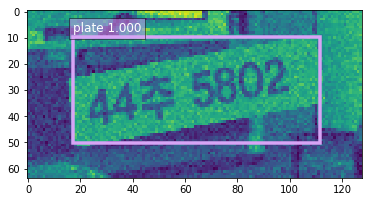

{'prediction': [[0.0, 0.9999899864196777, 0.04531791806221008, 0.30213266611099243, 0.9289298057556152, 0.6831735372543335]]}


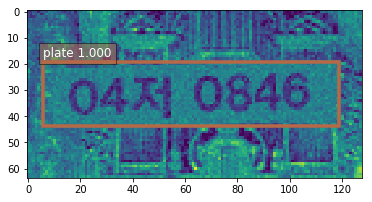

{'prediction': [[0.0, 0.9999003410339355, 0.19029474258422852, 0.3204784393310547, 0.8024267554283142, 0.6853176355361938]]}


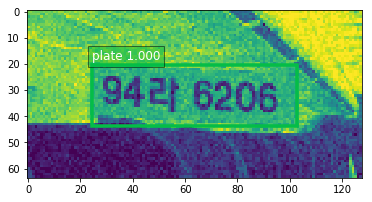

{'prediction': [[0.0, 0.9998575448989868, 0.06969457864761353, 0.24233396351337433, 0.9240140318870544, 0.735538899898529]]}


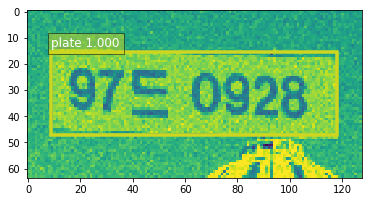

{'prediction': [[0.0, 0.9999614953994751, 0.20230838656425476, 0.324221670627594, 0.7647449970245361, 0.641003429889679]]}


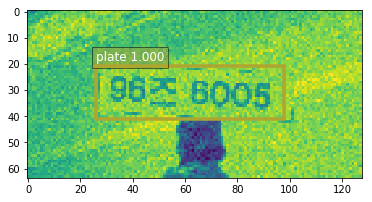

{'prediction': [[0.0, 0.9999361038208008, 0.2576943635940552, 0.3364753723144531, 0.7631393671035767, 0.647545337677002]]}


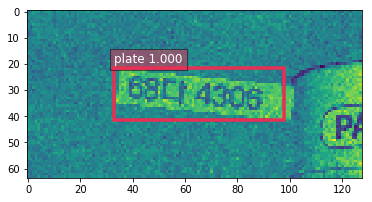

{'prediction': [[0.0, 0.9999755620956421, 0.2073541283607483, 0.3406544029712677, 0.7846402525901794, 0.6386505365371704]]}


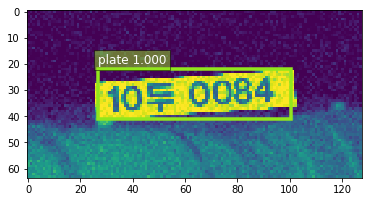

{'prediction': [[0.0, 0.9992319345474243, 0.04484236240386963, 0.1800888478755951, 0.9223757386207581, 0.8137339353561401]]}


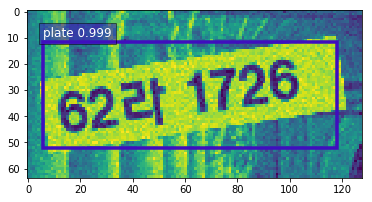

{'prediction': [[0.0, 0.9999579191207886, 0.206047922372818, 0.3435056507587433, 0.8434301614761353, 0.6376992464065552]]}


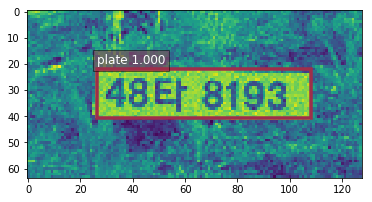

{'prediction': [[0.0, 0.9998714923858643, 0.22368282079696655, 0.2995836138725281, 0.7698282599449158, 0.6561214327812195]]}


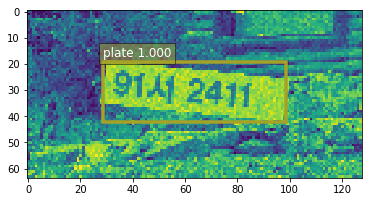

CPU times: user 1.85 s, sys: 29.2 ms, total: 1.88 s
Wall time: 13.2 s


In [23]:
%%time
for i in test_imgs[:10]:
    ifile = 'od/od-validation/' + i
    with open(ifile, "rb") as image:
        f = image.read()
        b = bytearray(f)
        results = object_detector.predict(b)
        detections = json.loads(results)
        print(detections)
    visualize_detection(ifile, detections['prediction'], 'plate', threshold)

## Endpoint API test

* You can invoke SageMaker endpoint from business application as below:

In [24]:
import boto3
runtime = boto3.Session().client('runtime.sagemaker')

In [25]:
od_endpoint = object_detector.endpoint
response = runtime.invoke_endpoint(EndpointName=od_endpoint,
                                   ContentType='image/png',
                                   Body=b)
response['Body']

In [26]:
test_result = response['Body'].read()

In [27]:
print(json.loads(test_result)['prediction'])

[[0.0, 0.9998714923858643, 0.22368282079696655, 0.2995836138725281, 0.7698282599449158, 0.6561214327812195]]


## Delete endpoint

* Delete endpoint to avoid additional charges.

In [32]:
sagemaker.Session().delete_endpoint(object_detector.endpoint)

INFO:sagemaker:Deleting endpoint with name: object-detection-2019-04-22-14-47-13-527


## Next step
Move to [Lab2](Lab2-custom-CNN-script-with-TF.ipynb) to develop a model to recongnize license plate characters.